# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [ ]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [2]:
ds_train = pd.read_csv("/home/aleb/dmeyf23/datasets/competencia_01.csv")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [3]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop("clase_ternaria", axis=1)
ds_bajas = ds_bajas.drop("clase_ternaria", axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [9]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 500,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [5]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
8,mrentabilidad_annual,255
51,cpayroll_trx,238
72,mcomisiones_mantenimiento,156
11,mpasivos_margen,155
22,mcuentas_saldo,151
...,...,...
75,cforex,0
70,mtarjeta_master_descuentos,0
69,ctarjeta_master_descuentos,0
68,mtarjeta_visa_descuentos,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [6]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [8]:
print()
cliente_idx = 7 # el 

In [55]:
pd.concat([Xbajas.iloc[7], shap_bajas.iloc[7]], axis=1)

,39314,7
numero_de_cliente,118091098.0,0.008575
foto_mes,202103.0,0.000000
active_quarter,0.0,-0.000362
cliente_vip,0.0,0.000000
internet,1.0,-0.000434
...,...,...
Visa_fechaalta,827.0,-0.001224
Visa_mconsumototal,0.0,0.000000
Visa_cconsumos,0.0,0.001528
Visa_cadelantosefectivo,0.0,0.000000


Y consolidamos sus importancias

In [ ]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter                       0.841637
cpayroll_trx                       0.523402
mpayroll                           0.222474
mtarjeta_visa_consumo              0.208924
mcomisiones_mantenimiento          0.206178
                                     ...   
ccheques_emitidos_rechazados       0.000000
mcheques_depositados_rechazados    0.000000
ccheques_depositados_rechazados    0.000000
mcheques_emitidos                  0.000000
mforex_buy                         0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

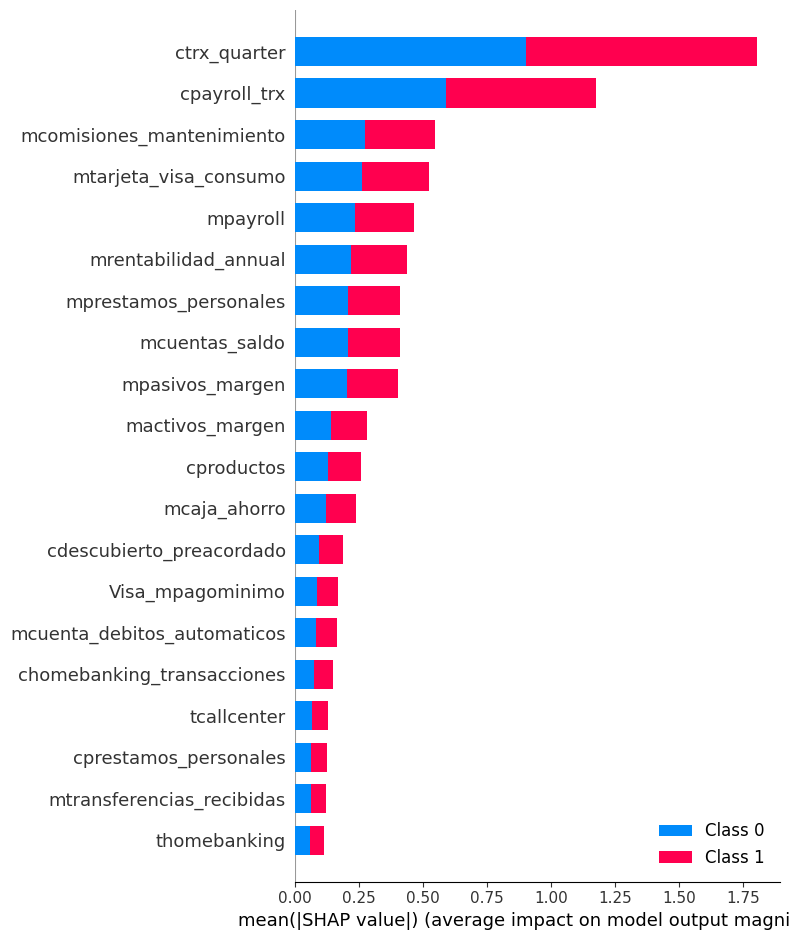

In [ ]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

¿Se podrá hacer una clusterización sobre los valores de shap?

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

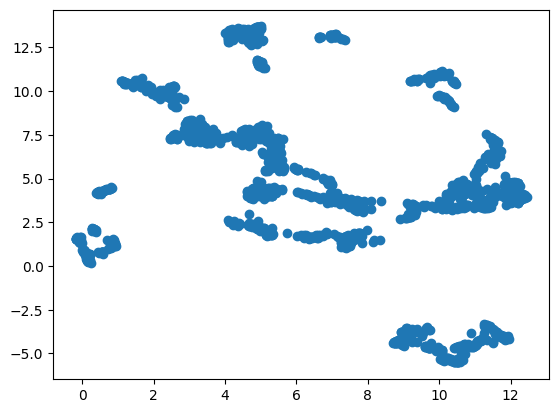

In [ ]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

(array([962., 448., 261., 151.,  81.,  58.,  26.,  13.,   5.,   7.]),
 array([0.00498547, 0.05839818, 0.11181088, 0.16522358, 0.21863628,
        0.27204899, 0.32546169, 0.37887439, 0.43228709, 0.4856998 ,
        0.5391125 ]),
 <BarContainer object of 10 artists>)

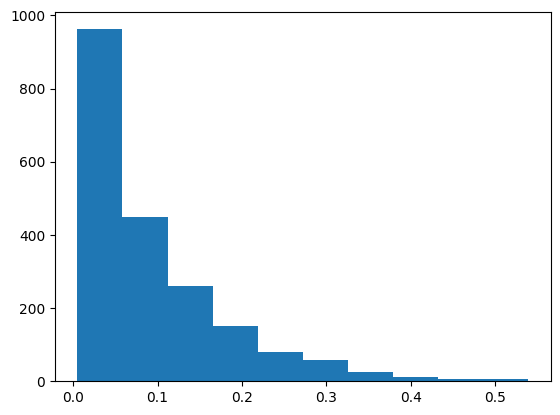

In [8]:
p_bajas = gbm.predict(Xbajas)
plt.hist(p)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


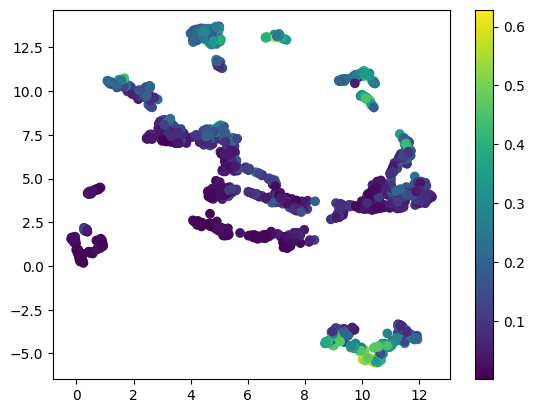

In [ ]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p)
plt.colorbar(sc)
plt.show()


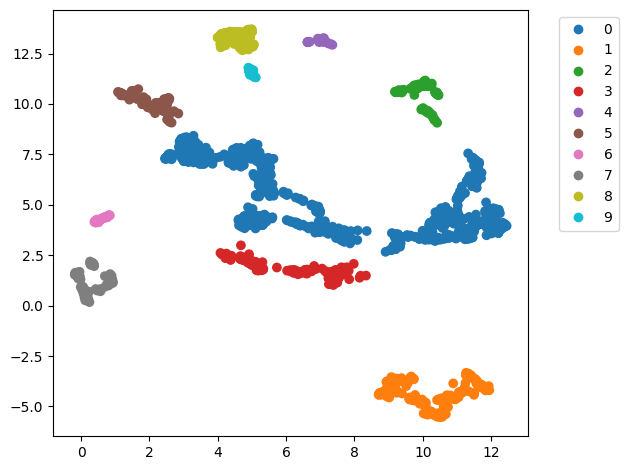

In [ ]:

hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='tab10')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

chomebanking_transacciones    0.055489
thomebanking                  0.026331
cmobile_app_trx               0.011965
tcallcenter                   0.011174
Visa_Fvencimiento             0.010109
                                ...   
mcuentas_saldo               -0.247311
mtarjeta_visa_consumo        -0.301069
cdescubierto_preacordado     -0.508122
cpayroll_trx                 -0.683044
ctrx_quarter                 -1.357347
Length: 154, dtype: float64

In [ ]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False)

mprestamos_personales         1.000644
cprestamos_personales         0.240807
mrentabilidad_annual          0.064519
chomebanking_transacciones    0.030079
internet                      0.012880
                                ...   
mpayroll                     -0.140802
mcomisiones_mantenimiento    -0.222246
mtarjeta_visa_consumo        -0.278806
cpayroll_trx                 -0.318618
ctrx_quarter                 -0.976662
Length: 154, dtype: float64

In [ ]:
Xbajas.loc[y.labels_ == 1]["cprestamos_personales"].mean()

0.1383399209486166

In [ ]:
Xbajas.loc[y.labels_ == 6]["cprestamos_personales"].mean()

7.261904761904762

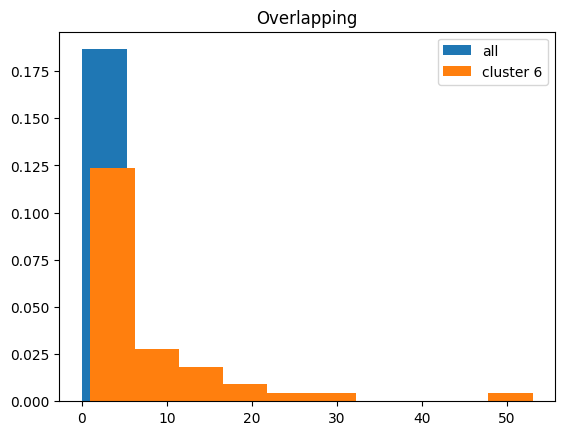

In [ ]:
plt.hist(Xbajas.loc[:]["cprestamos_personales"], label='all', density=True)
plt.hist(Xbajas.loc[y.labels_ == 6]["cprestamos_personales"], label='cluster 6', density=True)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

## Random Forest distance

Armamos un conjunto de datos

In [ ]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [ ]:
XRF = Xtrain.iloc[rf_index]
yRF = ytrain.iloc[rf_index]

In [ ]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Umap de rf

using precomputed metric; inverse_transform will be unavailable


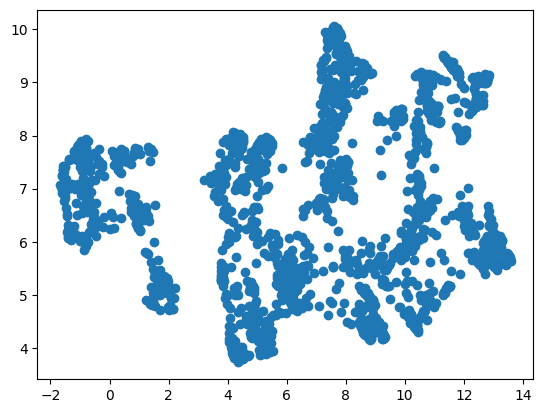

In [ ]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1])

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])